# CASE CAP GEMINI INVENT

**Objectifs de la partie 3**

L'objectif ici est simple: créer une dictionnaire de modèles de régression entraînés sur les trois datasets puis tester leurs performances respectives (les datasets seront simplement nommés: rough_ml, by_hand et by_reg qui on le rappelle ont été obtenus sans sélection des variables, par sélection à la main et par elastic net.)

In [51]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import clone
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [41]:
rough_ml = pd.read_csv('df_ml/df_for_ml.csv')
by_hand = pd.read_csv('df_ml/ml_selected_byhand.csv')
by_reg = pd.read_csv('df_ml/ml_selected_byreg.csv')
unnorm_target = pd.read_csv('df_ml/unnormalized_target.csv')

df_dict = {'rough_ml':rough_ml, 'by_hand':by_hand, 'by_reg':by_reg}

## Description des modèles:
---

### Modèles de Régression Implementés 📈

#### Régression Linéaire Multiple 🧮
- **Description**: La régression linéaire multiple est un modèle statistique qui cherche à prédire une variable dépendante à partir de plusieurs variables indépendantes, en supposant une relation linéaire entre elles.
- **Utilisation**: Elle est idéale pour mettre en lumière des relations simples et pour servir de benchmark pour des 
modèles plus sophistiqués

#### Elastic Net 🕸️
- **Description**: Elastic Net est une méthode de régression régularisée qui combine les pénalités L1 et L2 des régularisations Lasso et Ridge. 
- **Utilisation**: Très utile lorsque plusieurs caractéristiques sont corrélées entre elles. Elastic Net peut aider à réduire le surapprentissage en introduisant ces pénalités.
- **Avantages**: Permet une sélection de caractéristiques automatique et la régularisation. Performant lorsque le nombre de prédicteurs est très grand.
- **Inconvénients**: Difficile de choisir ses paramètres.

#### Random Forest 🌳
- **Description**: Un modèle qui opère en construisant un grand nombre d'arbres de décision au moment de l'entraînement et en produisant la moyenne des prédictions de ces arbres pour la prédiction finale.
- **Utilisation**: Excellent pour capturer des relations non linéaires sans nécessiter une transformation manuelle des caractéristiques.
- **Avantages**: Réduit le risque de surapprentissage. Importances des caractéristiques facilement extractibles ce qui améliore l'"explicabilité" du modèle.
- **Inconvénients**: Moins interprétable qu'un modèle de régression linéaire.

#### XGBoost 🚀
- **Description**: XGBoost (Extreme Gradient Boosting) est un algorithme d'apprentissage ensembliste qui construit de manière itérative des arbres de décision de manière à minimiser une fonction de perte.
- **Utilisation**: Idéal pour des performances élevées et la rapidité sur des tâches de prédiction.
- **Avantages**: Très performant, capable de gérer des données de grande dimension et des relations non linéaires.
- **Inconvénients**: Peut être sujet au surapprentissage si les hyperparamètres ne sont pas bien choisis. Moins intuitif à comprendre et interpréter.

#### CatBoost 🐱🚀
- **Description**: CatBoost est un algorithme de boosting qui utilise des arbres de décision et est optimisé pour traiter efficacement les variables catégorielles comme l'état d'un bien immobilier etc...
- **Utilisation**: Particulièrement efficace pour les ensembles de données avec de nombreuses caractéristiques catégorielles.
- **Avantages**: Offre une bonne performance avec peu de paramétrage. Gère bien les données catégorielles sans prétraitement.
- **Inconvénients**: Encore et toujours un risque non négligeable de surapprentissage, comme pour tous les algorithmes de boosting.

---

## Construction de la Grille de paramètres

In [42]:
y_mean = unnorm_target['valeur_fonciere'].mean(axis=0) 
y_std = unnorm_target['valeur_fonciere'].std(axis=0)
y_mean, y_std

(211288.86529576036, 133993.18394892054)

In [43]:

models_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Elastic Net': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.9]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 2, 3, 4]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [10, 50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [None, 2, 3, 4],
            'objective': ['reg:squarederror']
        }
    },
    #'CatBoost': {
    #    'model': CatBoostRegressor(verbose=0),  # verbose=0 empêche les spams
    #    'params': {
    #        'iterations': [10, 50, 100],
    #        'learning_rate': [0.01, 0.1, 0.5],
    #        'depth': [2, 3, 4],
    #        'loss_function': ['RMSE']
    #    }
    #}
}


<span style="color:red">**Note importante:**</span> 

Ici nous donnons comme métriques d'évaluation la MSE, le R2 score ainsi que le MAPE. Ce dernier peut sembler peu pertinent du fait que les étiquettes soient normalisées (et MAPE est TRES sensible au petites valeurs) ou que xgboost ne l'utilise pas dans notre exemple comme fonction de perte... Cependant nous allons tout de même calculer une version modifiée par nos soins de cette métrique pour satisfaire un double objectif: mettre en perspective la performance du modèle avec de nouvelles métriques, retourner une métrique interprétable pour le client.

Expliquons en quoi nous l'avons modifiée:
- La formule initiale 

`mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100`

- Sa version modifiée 

`modified_mape = np.mean(np.abs((y_test - y_pred) * y_std / (y_test*y_std + y_mean))) * 100`

Cette deuxième version multiplie l'écart de prédiction par la std réelle de y afin de rendre compte de ce que cet écart observé signifie réellement lorsque l'on considère les valeurs foncieres non normalisée (std est considérée ici comme un écart moyen de valeurs à leur moyenne) 

On divise par y_test*y_std + y_mean afin d'effectuer un rapport sur une variable 'dénormalisée'

In [44]:
def best_model_selector(df_dict, target_feature, y=None):

    best_models = {}

    for df_name, df in df_dict.items():
        X = df.drop(target_feature, axis=1)
        if y is None:
            y = df[target_feature] 
        
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        categorical_features_indices = [i for i, col in enumerate(X.columns) if col in categorical_cols]

        X_encoded = pd.get_dummies(X, drop_first=True)
        X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

        print(50*'-', 'stats for : ', df_name, 50*'-')

        for name, mp in models_params.items():
            
            print(30*'-', name)

            model = clone(mp['model']) # On s'assure que la validation croisée commencera avec un modèle non entraîné

            if name == 'CatBoost':
                X_train, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)
                model.set_params(**{'cat_features': categorical_features_indices})
                params = mp['params']
            else:
                params = mp['params']

            grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            grid.fit(X_train, y_train)
            score = grid.score(X_test, y_test)
            
            y_pred = grid.best_estimator_.predict(X_test)
            # Scores additionnels visant à avoir d'autres perspectives
            r2 = r2_score(y_test, y_pred)
            if (y != unnorm_target['valeur_fonciere']).any():
                mape = np.mean(np.abs((y_test - y_pred) * y_std / (y_test*y_std + y_mean))) * 100
            else:
                mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100

            print(f"{name} MSE: {-score:.2f}")
            print(f"{name} R2: {r2:.2f}")
            print(f"{name} MAPE: {mape:.2f}")
            
            best_models[f'{name}_{df_name}'] = {'model': grid.best_estimator_, 
                                    'score': {'mse': -score, 
                                            'r2': r2, 
                                            'mape': mape}, 
                                'df': df_name}
    return best_models


In [47]:
best_models = best_model_selector(df_dict=df_dict, target_feature='valeur_fonciere');

-------------------------------------------------- stats for :  rough_ml --------------------------------------------------
------------------------------ Linear Regression
Linear Regression MSE: 273826880774065061888.00
Linear Regression R2: -262964839779657318400.00
Linear Regression MAPE: 311597388433.63
------------------------------ Elastic Net
Elastic Net MSE: 0.20
Elastic Net R2: 0.81
Elastic Net MAPE: 21.26
------------------------------ Random Forest
Random Forest MSE: 0.16
Random Forest R2: 0.85
Random Forest MAPE: 16.86
------------------------------ XGBoost
XGBoost MSE: 0.16
XGBoost R2: 0.84
XGBoost MAPE: 18.06
-------------------------------------------------- stats for :  by_hand --------------------------------------------------
------------------------------ Linear Regression
Linear Regression MSE: 0.18
Linear Regression R2: 0.83
Linear Regression MAPE: 21.64
------------------------------ Elastic Net
Elastic Net MSE: 0.20
Elastic Net R2: 0.80
Elastic Net MAPE: 21.28
--

Et là, nous sommes très déçus. Pourquoi? Parce que comme vu précédemment sur les variables sélectionnées, la valeur foncière dépend surtout de la surface du bâti, c'est même la feature jugée la plus importante par notre premier modèle catboost, ainsi que le prix moyen des voisins qui semble avoir une corrélation linéaire avec la valeur foncière... Ainsi nos modèles de boosting fonctionnent (sur les variables sélectionnées) pas bien mieux (du point de vue de la MSE) qu'une simple régression linéaire.

<span style="color:red">**Note importante:**</span> 

Nous préférons ici prédire des étiquettes normalisées étant donnée leur dispersions et la plage très étendue de valeurs qu'elles peuvent prendre. Par ailleurs, l'elastic net ne converge pas si l'on ne normalise pas les étiquettes. Cela ne nous empêche d'ailleurs pas de reconstruire a posteriori les prédictions originales en les multipliant par y_std et en leur ajoutant y_mean. 

## Quelles variables pour la prédiction? 

In [52]:
feature_importances_best_model = best_models['XGBoost_by_hand']['model'].feature_importances_

importance_df = pd.DataFrame({'Feature': by_hand.drop('valeur_fonciere', axis=1).columns, 'Importance': feature_importances_best_model})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(importance_df)

Feature Importance:
                      Feature  Importance
0         surface_reelle_bati    0.447676
16           evaluation_agent    0.108780
13         prix_moyen_voisins    0.103443
1             surface_terrain    0.076925
12       distance_toulouse_km    0.060463
3                   longitude    0.058377
4                    latitude    0.035554
15                      agent    0.019837
8            carreau_Log_av45    0.016912
5             carreau_Ind_snv    0.013923
9           carreau_Log_45_70    0.010336
11             distance_cv_km    0.009882
10                      MED16    0.008913
14                 type_local    0.008781
2   nombre_pieces_principales    0.007952
6            carreau_Men_surf    0.006408
7            carreau_Men_coll    0.005839


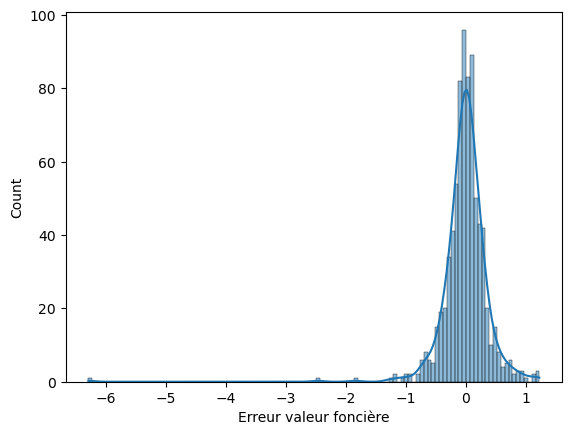

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

X = by_hand.drop('valeur_fonciere', axis=1)
y = by_hand['valeur_fonciere']
X_encoded =  pd.get_dummies(X, drop_first=True)

_, X_test, _, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
y_pred = best_models['XGBoost_by_hand']['model'].predict(X_test)

sns.histplot((y_pred - y_test), kde=True)
plt.xlabel('Erreur valeur foncière')
plt.show();

## Conclusion

On le voit dans le dataframe ci-dessus la variable ayant le pouvoir de prédiction le plus fort n'est autre que la surface réelle du bâti, cependant l'appréciation des agents immobiliers est aussi essentielle (10% du pouvoir de prédiction), soit autant que les prix moyens des biens voisins. Ce modèle concilie donc efficacement une approche métier promue par l'agence et des techniques nouvelles de machine learning. 

On le voit également, ce modèle présente une mean square error de 0.16, un R2 score de 0.85 soit de bonnes performances pour un modèle de régression. La distribution des erreur est symétrique, on pourrait par exemple ajouter un biais afin de n'obtenir que des prédictions positives.

**Supplément: tester la validité de nos métriques**

In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

mu, sigma = 2, 0.4
y = np.random.lognormal(mu, sigma, 1000)

scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten() 

y_train, y_test = train_test_split(y_scaled, test_size=0.2, random_state=42)

y_pred = y_test * 0.7

y_mean = np.mean(y_scaled)
y_std = np.std(y_scaled)

modified_mape = np.mean(np.abs((y_test - y_pred) * y_std / (y_test*y_std + y_mean))) * 100

print(f"Modified MAPE: {modified_mape:.2f}%")


Modified MAPE: 30.00%


La distribution de y dans notre exemple:

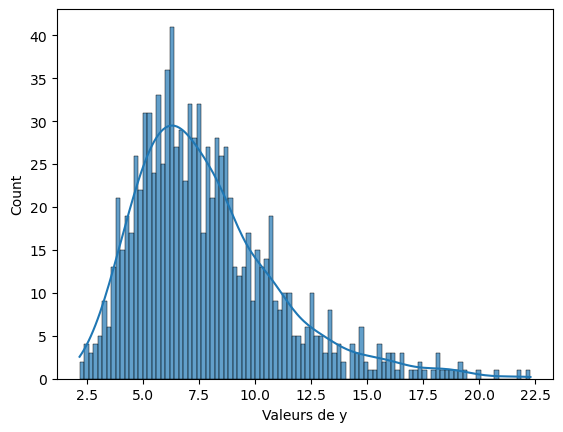

In [64]:
sns.histplot(y, bins=100, kde=True, alpha=0.7)
plt.xlabel('Valeurs de y')
plt.show();

Le MAPE modifié semble faire bon effet même s'il surestime un peu les écarts (ce qui n'est pas si mal)! 